# Init

In [1]:
import pandas as pd
import numpy as np
from numpy import mean
from numpy import std

import matplotlib.pyplot as plt
from datetime import datetime as dt, timedelta

from helpers import *
# Some of the statics can be found in init.py
import init as util

from dataprep import  *

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedKFold, StratifiedKFold, GridSearchCV
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# make the graphs actually viewable
plt.rcParams['figure.figsize'] = [6, 4]
plt.rcParams['figure.dpi'] = 200

class Settings(object):
    incident_window_size = 7 # days (used for N-Day rate)
    change_rate_window_size = 7 # days (sliding window size)
    off_day_relevance_window = 14 # days (used in the OffDayFactor)
    # timeframe used from the base data. Had some instances where data at the start or end got sketchy, so a clear cut-off produced better results
    timeframe_start = dt.strptime('2020-03-15',"%Y-%m-%d")
    timeframe_end = dt.strptime('2021-12-31',"%Y-%m-%d")
    training_columns = ['NDRC_SW_Yesterday','OffDayFactor', 'OffDay'] # columns used in training the algorithms

    # Data sources
    generate_data = False       # read data from original source
    save_generated_data = True  # write the data to the datapreparation cache files
    load_pregenerated_data = True # load the data from the pregenerated cache files (replaces data from original source in this ipynb)
    
    base_dir = "./"
    data_dir = base_dir + "datasets/"
    source_dir = data_dir + 'orig/'

    # all paths relative to this document
    original_be_data = source_dir + 'COVID19BE_CASES_AGESEX.csv'
    original_nl_data = source_dir + 'COVID-19_aantallen_gemeente_cumulatief.csv'
    original_de_data = source_dir + 'RKI_COVID19_Nordrhein-Westfalen.csv'

    # cache files
    emr_infection_data = data_dir + "EMR_prepared.csv"
    de_reference_data = data_dir + "de_ref_cal.csv"
    nl_reference_data = data_dir + "nl_ref_cal.csv"
    be_reference_data = data_dir + "be_ref_cal.csv"

settings = Settings()

In [2]:
emr_df = pd.read_csv(settings.emr_infection_data)
emr_df = addDateTypeColumn(emr_df,'Date')

be_ref_df, nl_ref_df, de_ref_df = loadRefData(settings)

No handles with labels found to put in legend.
No handles with labels found to put in legend.


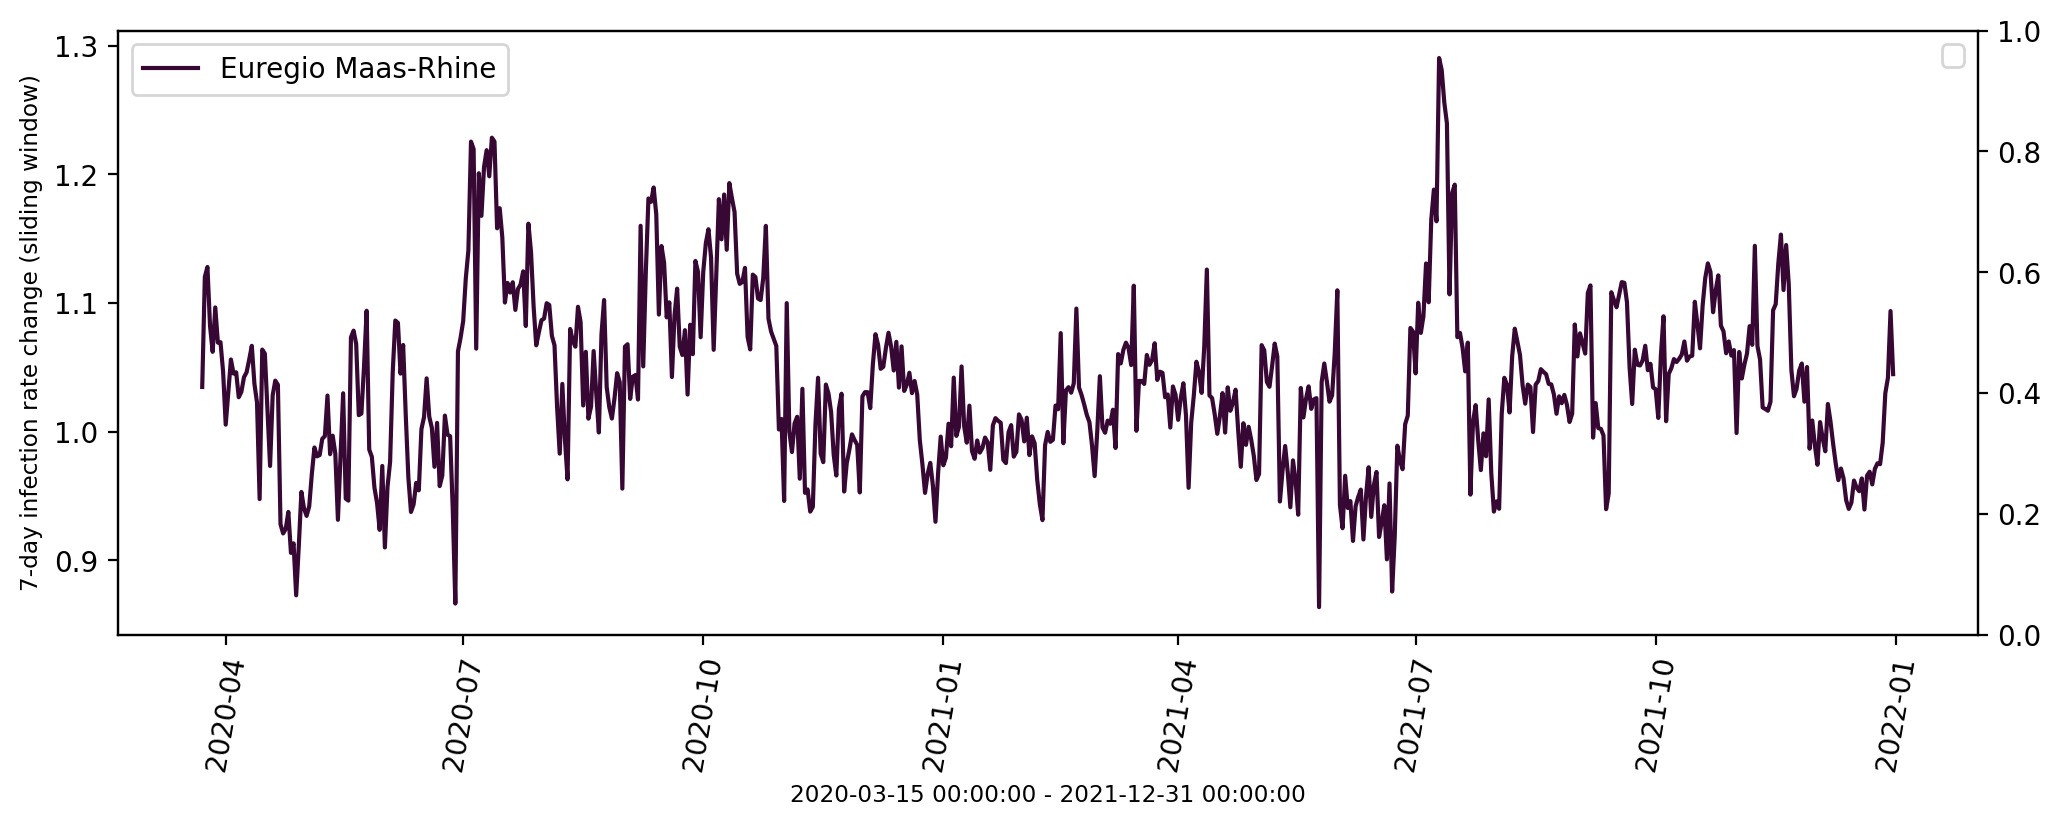

No handles with labels found to put in legend.
No handles with labels found to put in legend.


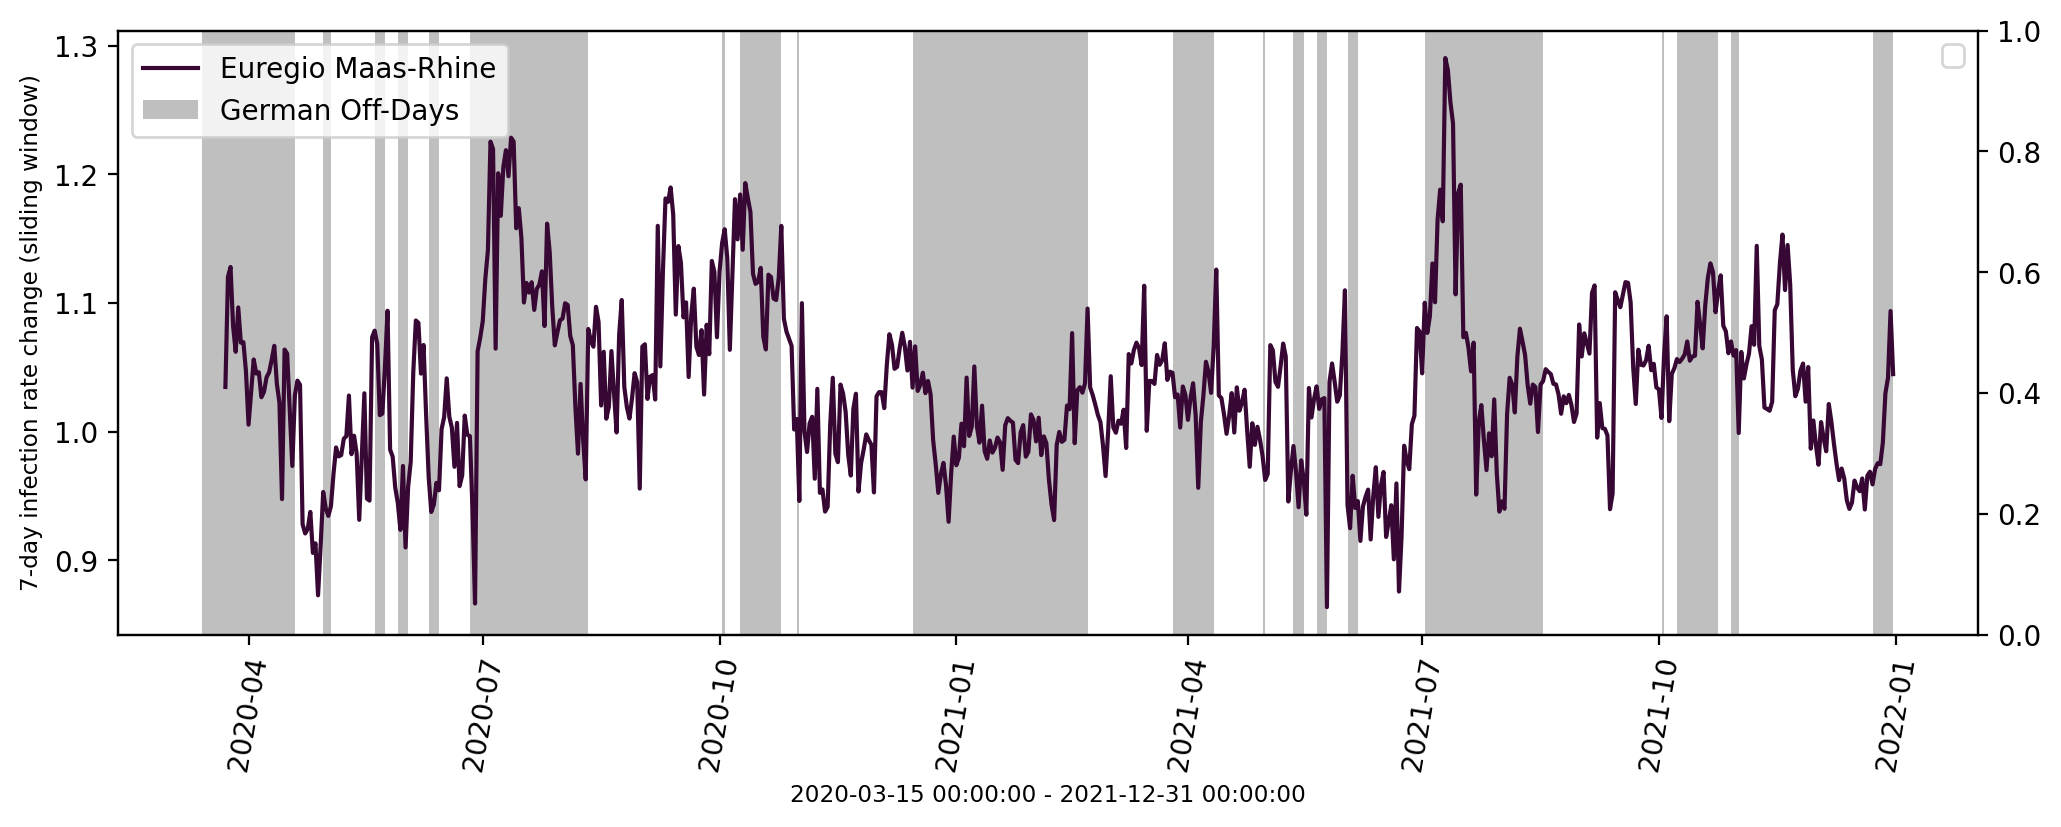

In [9]:
# sketchGraph(df, provinces, settings, refDf = None, streakLabel='Off days', offDayStreak=False, offDayFactor = False, plotsize=[12,4]):
sketchGraph(emr_df, {40}, settings, plotsize=[12,4])
sketchGraph(emr_df, {40}, settings, refDf = de_ref_df, streakLabel='German Off-Days', offDayStreak=True ,plotsize=[12,4])

# Inhabitants - Pie

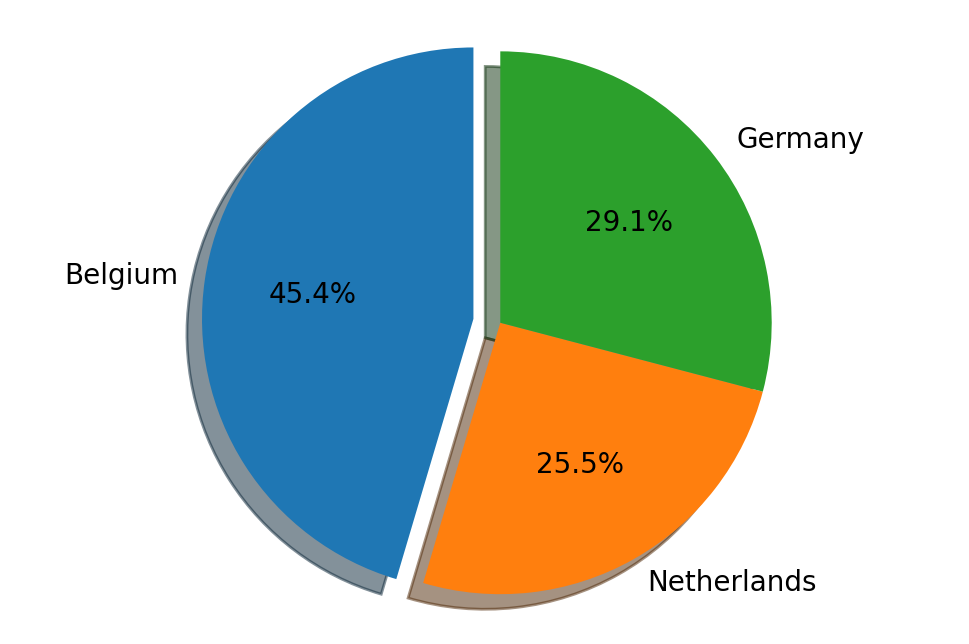

In [4]:
province_df = pd.DataFrame(util.province_size.items(), columns=['Id','Inhabitants'])
province_df['Label'] = util.class_labels.values()
province_df['Explode'] = 0
province_df.loc[province_df['Id'] == 10 ,'Explode'] = 0.1

province_df = province_df.loc[province_df['Id'].isin({10,20,30})]

explode = tuple(list(province_df['Explode']))  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(province_df['Inhabitants'], explode=explode, labels=province_df['Label'], autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

fig1.set_facecolor('white')
plt.show()